Implementing a Logistic Regression Classifier in PyTorch

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [3]:
df = pd.read_csv("../Unit1/data/perceptron-toydata-truncated.txt", sep="\t")
df.head()

,x1,x2,label
0,0.77,-1.14,0
1,-0.33,1.44,0
2,0.91,-3.07,0
3,-0.37,-1.91,0
4,-0.63,-1.53,0


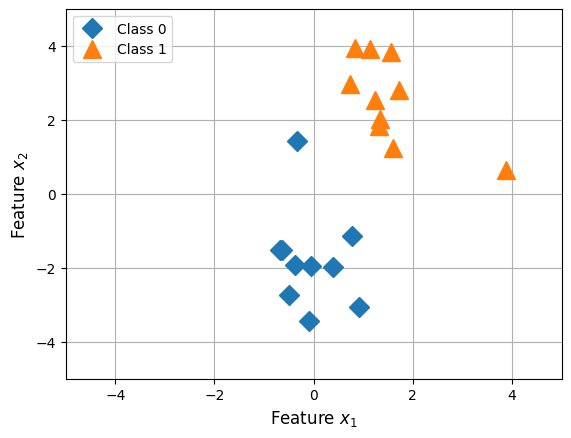

In [5]:
x_train = df[["x1", "x2"]].values
y_train = df["label"].values

np.bincount(y_train) # binary classification 10 label - 0 and 10 label - 1

plt.plot(
    x_train[y_train == 0, 0],
    x_train[y_train == 0, 1],
    marker = "D",
    markersize = 10,
    linestyle = "",
    label = "Class 0"
)

plt.plot(
    x_train[y_train == 1, 0],
    x_train[y_train == 1, 1],
    marker = "^",
    markersize = 13,
    linestyle = "",
    label = "Class 1"
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()

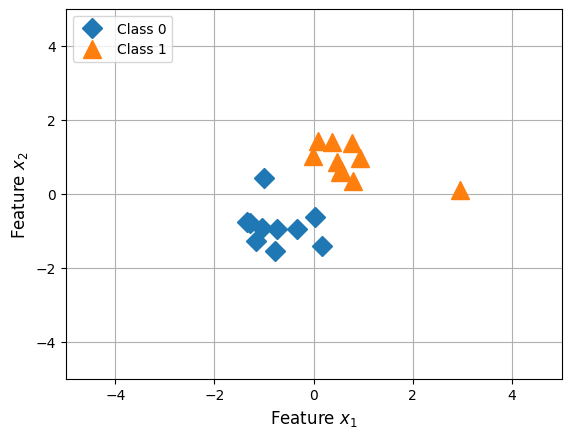

In [6]:
x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)


plt.plot(
    x_train[y_train == 0, 0],
    x_train[y_train == 0, 1],
    marker = "D",
    markersize = 10,
    linestyle = "",
    label = "Class 0"
)

plt.plot(
    x_train[y_train == 1, 0],
    x_train[y_train == 1, 1],
    marker = "^",
    markersize = 13,
    linestyle = "",
    label = "Class 1"
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()

In [10]:

from typing import List

class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features: int) -> int:
        super().__init__()
        self.linear = torch.nn.Linear(num_features, 1)
    
    def forward(self, observations: List[float]):
        logits = self.linear(observations)
        probs = torch.sigmoid(logits)

        return probs


In [9]:
torch.manual_seed(123)

model = LogisticRegression(num_features=2)

x = torch.tensor([1.1, 2.1])

with torch.no_grad(): # torch.inference_mode
    proba = model(x)

print(proba)

tensor([0.3500])


In [12]:

from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, obs, labels) -> None:
        super().__init__()
        self.features = torch.tensor(obs, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y
    
    def __len__(self):
        return self.labels.shape[0]


train_ds = MyDataset(x_train, y_train)
train_loader = DataLoader(
    dataset=train_ds,
    batch_size=10,
    shuffle=True
)

In [17]:
import torch.nn.functional as F

model = LogisticRegression(num_features=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

num_epochs: int = 10

for epoch in range(num_epochs):
    model = model.train()

    for batch_idx, (features, class_labels) in enumerate(train_loader):
        probs = model(features)

        loss = F.binary_cross_entropy_with_logits(probs, class_labels.view(probs.shape))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch+1}, Loss: {loss:.3f}")




Epoch: 1, Loss: 0.645
Epoch: 1, Loss: 0.639
Epoch: 2, Loss: 0.511
Epoch: 2, Loss: 0.770
Epoch: 3, Loss: 0.550
Epoch: 3, Loss: 0.729
Epoch: 4, Loss: 0.673
Epoch: 4, Loss: 0.603
Epoch: 5, Loss: 0.670
Epoch: 5, Loss: 0.604
Epoch: 6, Loss: 0.518
Epoch: 6, Loss: 0.754
Epoch: 7, Loss: 0.617
Epoch: 7, Loss: 0.652
Epoch: 8, Loss: 0.592
Epoch: 8, Loss: 0.676
Epoch: 9, Loss: 0.590
Epoch: 9, Loss: 0.675
Epoch: 10, Loss: 0.624
Epoch: 10, Loss: 0.638


Evaluation

In [19]:
pred = torch.where(probs > 0.1, 1, 0)
pred

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

In [21]:
def compute_accuracy(model, dataloader):
    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, class_labels) in enumerate(dataloader):
        with torch.inference_mode():
            probas = model(features)
        
        pred = torch.where(probas > 0.5, 1, 0)
        lab = class_labels.view(pred.shape).to(pred.dtype)

        compare = lab == pred
        correct = correct + torch.sum(compare)
        total_examples = total_examples + len(compare)
    
    return correct / total_examples

train_acc = compute_accuracy(model, train_loader)
print(f"Accuracy: {train_acc}")



Accuracy: 1.0


In [26]:
def plot_boundary(model):
    w1, w2 = model.linear.weight[0][0].detach(), model.linear.weight[0][1].detach()
    b = model.linear.bias[0].detach()

    x1_min = -20
    x2_min = (-(w1 * x1_min) -b) / w2
    x1_max = 20
    x2_max = (-(w1 * x1_max) -b) / w2

    return x1_min, x1_max, x2_min, x2_max

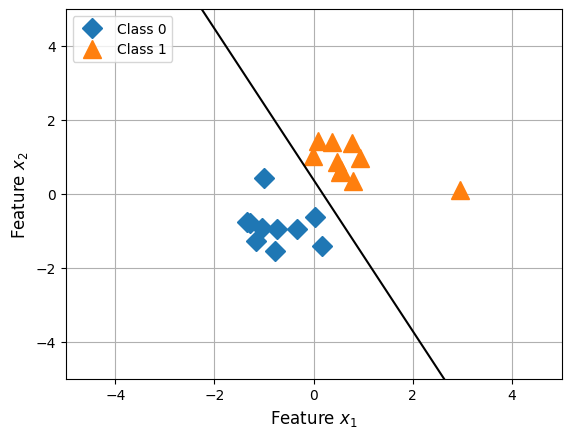

In [27]:

x1_min, x1_max, x2_min, x2_max = plot_boundary(model)


plt.plot(
    x_train[y_train == 0, 0],
    x_train[y_train == 0, 1],
    marker = "D",
    markersize = 10,
    linestyle = "",
    label = "Class 0"
)

plt.plot(
    x_train[y_train == 1, 0],
    x_train[y_train == 1, 1],
    marker = "^",
    markersize = 13,
    linestyle = "",
    label = "Class 1"
)

plt.plot([x1_min, x1_max], [x2_min, x2_max], color="k")
plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()